<a href="https://colab.research.google.com/github/AdrianduPlessis/UBI_Effects/blob/master/Crime_rates_vs_Gini_Coefficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Installs and Imports

This notebook explores the relationship between income inequality and crime rates (on a per county level). It is an single link in a hypothesis chain that hopes to make valuable conclusions about the effects Universal Basic Income in relation to the Human experience.  
  

**Goal**: Determine how much of the variation in crime-rates can be explained by Income Inequality.  

**Current Progress**: Currently the model represents an incremental, though insignificant improvement over a mean-baseline.    

*   Foundational project data has been sourced.
*   Data Engineering methods were used to create a common key on which to merge the relevant data.
*   Crime incidences and population were used to engineer crime-rates.
*   Mean-baseline established
*   Fast First Linear Regression Model
*   Experimental Random Tree Regressor Model: Does not exceed Fast First.
*   Pattern exploration
*   Engineered overall preportion of crimetype to identify anomalies.


**Path Forward**:

*   Identify features requered to accuratly model crime-rates
*   Import, Clean, Merge and Wrangle new data
*   Ensure no confounding variables in terms of Income Inequality
*   Reach Statistically Significant Model Accuracy
*   Determine how much variation is explained by income inequality


**Current Results**: Inconclusive.

In [0]:
!pip install eli5

In [0]:
#importing necesary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from eli5.sklearn import PermutationImportance
%matplotlib inline

Using TensorFlow backend.


In [0]:
#importing necesary datasets
gini_5yr_est_2017 = pd.read_csv('https://raw.githubusercontent.com/AdrianduPlessis/UBI_Effects/master/data/gini_est_5yr_17.csv', skiprows=1)
adult_arrests = pd.read_csv('https://raw.githubusercontent.com/AdrianduPlessis/UBI_Effects/master/data/ICPSR_36399/DS0004/36399-0004-Data.tsv', sep='\t')
FIPS = pd.read_csv('https://raw.githubusercontent.com/AdrianduPlessis/UBI_Effects/master/data/all-geocodes-v2016.xlsx%20-%20Sheet1.csv', skiprows=4)

In [0]:
#Preparing datasets for merging

In [0]:
def change_id_to_fips(id):
  fips = int(id[-5:])
  return fips

def combine_cty_st_fips(cty, st):
  full_fips = st*1000 + cty
  return full_fips

In [0]:
gini_5yr_est_2017['Id'].apply(change_id_to_fips);

FIPS['FIPS'] = combine_cty_st_fips(FIPS['County Code (FIPS)'], FIPS['State Code (FIPS)'])
adult_arrests['FIPS'] = combine_cty_st_fips(adult_arrests['FIPS_CTY'], adult_arrests['FIPS_ST'])

In [0]:
#Note: missing gini data for 35 counties (based on shapes of dfs being merged)
arrest_by_ineq = adult_arrests.merge(gini_5yr_est_2017, left_on='FIPS', right_on='Id2')

###Data Cleaning and Feature Engineering

In [0]:
#Create dictionary to lookup State based on state FIPS
State_FIPS = FIPS[FIPS['County Code (FIPS)']==0]
State_FIPS = State_FIPS[State_FIPS['Summary Level']==40]
lookup_state_FIPS = dict(zip(State_FIPS['State Code (FIPS)'],
                             State_FIPS['Area Name (including legal/statistical area description)']))

adult_arrests['state'] = adult_arrests['FIPS_ST'].map(lookup_state_FIPS)

In [0]:
#Normalize reported incidences for population size

def control_for_population(df, feature, population):
  df[feature] = df[feature]/df[population]
  return df 

crime_types = ['VIOL', 'PROPERTY', 'MURDER', 'RAPE', 
               'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 
               'MVTHEFT','ARSON']

population = arrest_by_ineq['CPOPARST']

for crime in crime_types:
  arrest_by_ineq[crime] = arrest_by_ineq[crime]/population

#Drop NaNs (5 observations)
arrest_by_ineq = arrest_by_ineq.dropna()

###Train/Test/Val Split

In [0]:
y = arrest_by_ineq['Estimate; Gini Index']
X = arrest_by_ineq[crime_types]

#Train/Test Split
X_remaining, X_test, y_remaining, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

#Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_remaining, y_remaining, test_size=0.3, random_state=42)

###Establish mean baseline

In [0]:
def evaluate_model(predictions, true):
  mae = mean_absolute_error(predictions, true)
  r2e = mean_squared_error(predictions, true)
  print("Baseline: \n",
        "MAE: ", round(mae, 4), ' which is ', round(mae/true.mean()*100, 2), "%\n",
        "r^2 error: ", round(r2e, 7), '\n')

In [0]:
#mean baseline
y_baseline = [y_train.mean()] * len(y_train)
evaluate_model(y_baseline, y_train)

Baseline: 
 MAE:  0.0271  which is  6.11 %
 r^2 error:  0.00121 



###Fast First Model

In [0]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, y_train)  # perform linear regression
y_ff_pred = linear_regressor.predict(X_val)  # make predictions
evaluate_model(y_ff_pred, y_val)

Baseline: 
 MAE:  0.0262  which is  5.88 %
 r^2 error:  0.0011125 



Some observed improvement over mean baseline means there might be some predictive value in this dataset. This warrents a more robust model and efforts.

###Random Forest Regressor

In [0]:
model = RandomForestRegressor(criterion='mae', n_estimators=100, max_depth=5)
model.fit(X_train, y_train);

In [0]:
#Visualize feature importances to gain model insight
permuter = PermutationImportance(
    model,
    n_iter=2,
    random_state=42
)

permuter.fit(X_train, y_train)
feature_names = X_train.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names,
)

Weight,Feature
0.2859 ± 0.0178,ROBBERY
0.1069 ± 0.0257,BURGLRY
0.0492 ± 0.0002,LARCENY
0.0483 ± 0.0015,VIOL
0.0236 ± 0.0029,PROPERTY
0.0188 ± 0.0024,MVTHEFT
0.0187 ± 0.0037,MURDER
0.0180 ± 0.0009,RAPE
0.0164 ± 0.0012,ARSON
0.0121 ± 0.0044,AGASSLT


In [0]:
y_train_pred = model.predict(X_train)

#Checking for obvious overfitting
evaluate_model(y_train_pred, y_train)

Baseline: 
 MAE:  0.0224  which is  5.05 %
 r^2 error:  0.0009072 



In [0]:
y_val_pred = model.predict(X_val)
evaluate_model(y_val_pred, y_val)

Baseline: 
 MAE:  0.0261  which is  5.86 %
 r^2 error:  0.0011228 



The training set outperforming the validation set is an indicator of over-fitting. There is also no significant improvement over either the fast first model or the mean baseline.  
Continued effort modeling Gini Coefficients based on the current feature set would be wasteful. 

###Dataset investigation

If this dataset cannot be used to predict income inequality, let's see what information we can extract by visualizing the data.

In [0]:
#Overview
arrest_by_ineq.head(3)

,STUDYNO,EDITION,PART,IDNO,FIPS_ST,FIPS_CTY,CPOPARST,CPOPCRIM,AG_ARRST,AG_OFF,COVIND,VIOL,PROPERTY,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,FIPS,Id,Id2,Geography,Estimate; Gini Index,Margin of Error; Gini Index
0,9999,1,4,1,1,1,57217,54579,3,3,100.0000,0.002517,0.028401,0.000035,0.000315,0.000647,0.001521,0.006746,0.019400,0.002255,0.000245,1001,0500000US01001,1001,"Autauga County, Alabama",0.4501,0.0391
1,9999,1,4,2,1,3,198843,193083,14,13,96.0428,0.001876,0.020418,0.000020,0.000166,0.000312,0.001378,0.003872,0.015927,0.000619,0.000091,1003,0500000US01003,1003,"Baldwin County, Alabama",0.4618,0.0100
2,9999,1,4,3,1,5,27026,25154,5,4,96.0536,0.003589,0.024421,0.000111,0.000370,0.000518,0.002590,0.006327,0.016799,0.001332,0.000037,1005,0500000US01005,1005,"Barbour County, Alabama",0.4622,0.0148


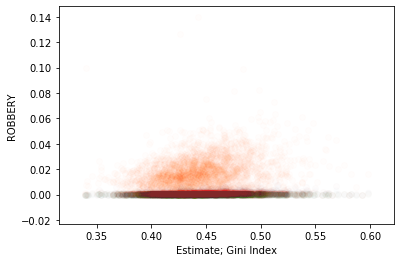

In [0]:
ax = sns.scatterplot(x=y, y=X['ROBBERY'], alpha=0.01)

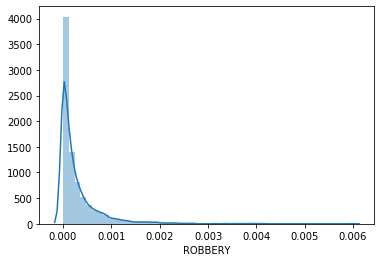

In [0]:
sns.distplot(X['ROBBERY'])

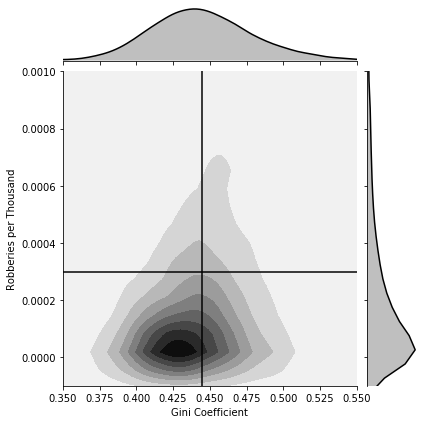

In [0]:
 r = sns.jointplot(x=y, y=X['ROBBERY'], kind="kde", color="k", ylim=(-0.0001,0.001), xlim=(0.35, 0.55));
 r.ax_joint.axvline(x=y.mean(), color='k')
 r.ax_joint.axhline(y=X['ROBBERY'].mean(), color='k')
 r.set_axis_labels(ylabel='Robberies per Thousand', xlabel='Gini Coefficient')
 

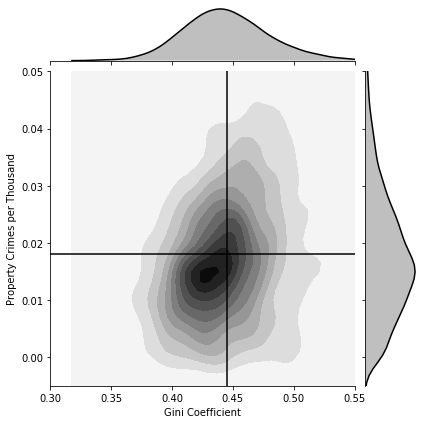

In [0]:
r = sns.jointplot(x=y, y=X['PROPERTY'], kind="kde", color="k", ylim=(-0.005,0.05), xlim=(0.3,0.55));
r.ax_joint.axvline(x=y.mean(), color='k')
r.ax_joint.axhline(y=X['PROPERTY'].mean(), color='k')
r.set_axis_labels(ylabel='Property Crimes per Thousand', xlabel='Gini Coefficient')

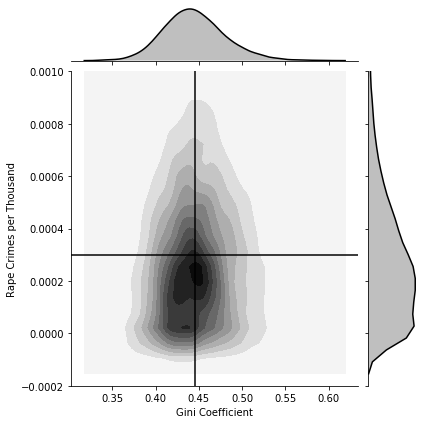

In [0]:
r = sns.jointplot(x=y, y=X['RAPE'], kind="kde", color="k", ylim=(-0.0002,0.001));
r.ax_joint.axvline(x=y.mean(), color='k')
r.ax_joint.axhline(y=X['RAPE'].mean(), color='k')
r.set_axis_labels(ylabel='Rape Crimes per Thousand', xlabel='Gini Coefficient')

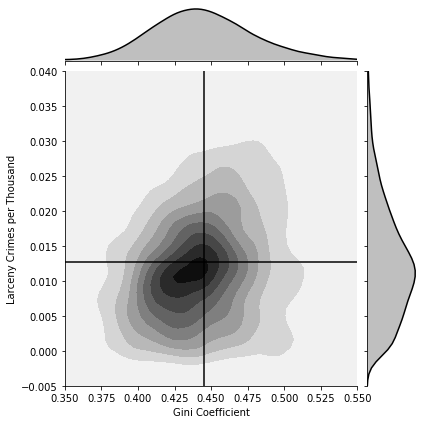

In [0]:
 r = sns.jointplot(x=y, y=X['LARCENY'], kind="kde", color="k", ylim=(-0.005, 0.04), xlim=(0.35, 0.55));
 r.ax_joint.axvline(x=y.mean(), color='k')
 r.ax_joint.axhline(y=X['LARCENY'].mean(), color='k')
 r.set_axis_labels(ylabel='Larceny Crimes per Thousand', xlabel='Gini Coefficient')

Observations: Generaly the higher the Gini, the broader the range of crime rates.

###Disproportional rate of crime compared to gini


In [0]:
reported_crimes = ['VIOL', 'PROPERTY', 'MURDER', 'RAPE', 
               'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 
               'MVTHEFT','ARSON']

def find_expected_proportion(df, features):
  totals = []
  proportions = []
  for feature in features:
    totals.append(df[feature].sum())
  
  for value in totals:
    proportions.append(value/sum(totals))

  return proportions

In [0]:
proportions = find_expected_proportion(adult_arrests, reported_crimes)
proportions

[0.06301344158051118,
 0.43576266699905825,
 0.0007556140425351276,
 0.005887981691784854,
 0.017315420599283645,
 0.039047936040215774,
 0.09091951788438883,
 0.3080959072303011,
 0.03674269943968404,
 0.0024588144922371514]